In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

#### Read in Price Data

In [2]:
def read_prices(file_name):
    prices = pd.read_csv(file_name)
    prices = prices.rename({'Adj Close': 'price'}, axis=1)
    prices = prices[['Date','price']]
    prices['Date'] = pd.to_datetime(prices['Date'])
    prices.set_index('Date', inplace=True)
    return prices

#### Convert to Log Returns

In [14]:
def calculate_log_returns(prices):
    returns: pd.DataFrame = np.log(prices/prices.shift(1))
    returns.dropna(inplace=True)
    return returns

#### Temporal train test split

In [4]:
def split_train_test(returns, ratio=0.66):
    split = int(len(returns) * ratio)
    train = returns.iloc[:split]
    test = returns.iloc[split:]
    return train, test

In [21]:
def plot_series(series, title):
    plt.figure(figsize=(12, 3))
    plt.xticks(rotation=45)
    plt.plot(series)
    plt.title(title)

In [5]:
SPY = read_prices('SPY.csv')
MSFT = read_prices('MSFT.csv')

In [8]:
# truncate both series to the start from 2023-01-03 and to end at latest common date
start_date = '2023-01-03'
latest_common_date = min(SPY.index[-1], MSFT.index[-1])

SPY = SPY[start_date:latest_common_date]
MSFT = MSFT[start_date:latest_common_date]

In [9]:
SPY

,price
Date,
2023-01-03,372.754242
2023-01-04,375.631989
2023-01-05,371.344757
2023-01-06,379.860504
2023-01-09,379.645111
...,...
2024-06-27,546.369995
2024-06-28,544.219971
2024-07-01,545.340027


In [10]:
MSFT

,price
Date,
2023-01-03,236.609222
2023-01-04,226.259186
2023-01-05,219.553360
2023-01-06,222.140869
2023-01-09,224.303726
...,...
2024-06-27,452.850006
2024-06-28,446.950012
2024-07-01,456.730011


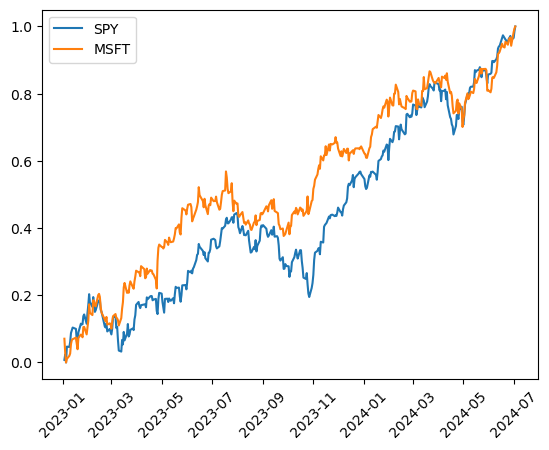

In [12]:
# normalize prices and then plot them to compare
max_spy = SPY['price'].max()
min_spy = SPY['price'].min()
max_msft = MSFT['price'].max()
min_msft = MSFT['price'].min()

norm_spy = (SPY['price'] - min_spy) / (max_spy - min_spy)
norm_msft = (MSFT['price'] - min_msft) / (max_msft - min_msft)

plt.plot(norm_spy, label='SPY')
plt.plot(norm_msft, label='MSFT')
plt.legend()
plt.xticks(rotation=45)
plt.show()


#### Observed price correlation between SPY and MSFT. Let's see if this applies for returns as well

In [16]:
# returns series 
spy_returns = calculate_log_returns(SPY)
msft_returns = calculate_log_returns(MSFT)

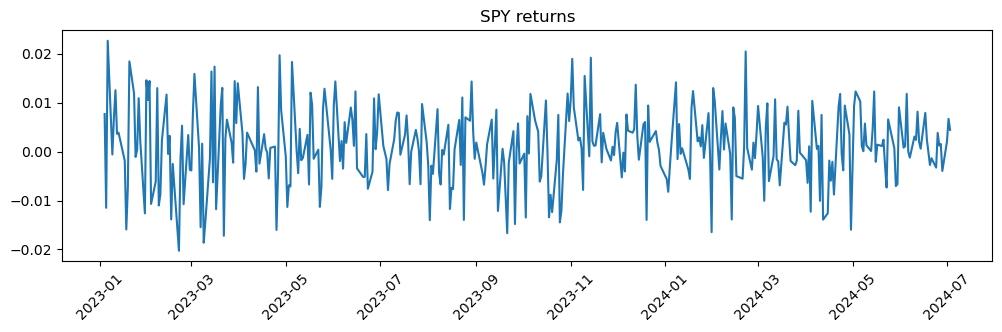

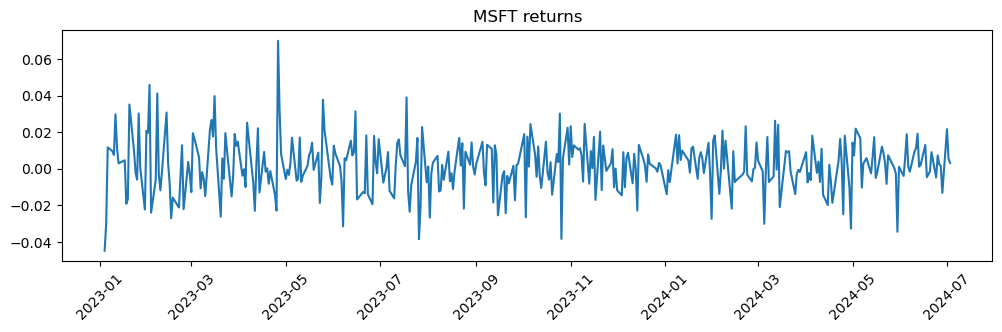

In [26]:
# plot SPY returns
plot_series(spy_returns, 'SPY returns')
plt.show()
plot_series(msft_returns, 'MSFT returns')
plt.show()

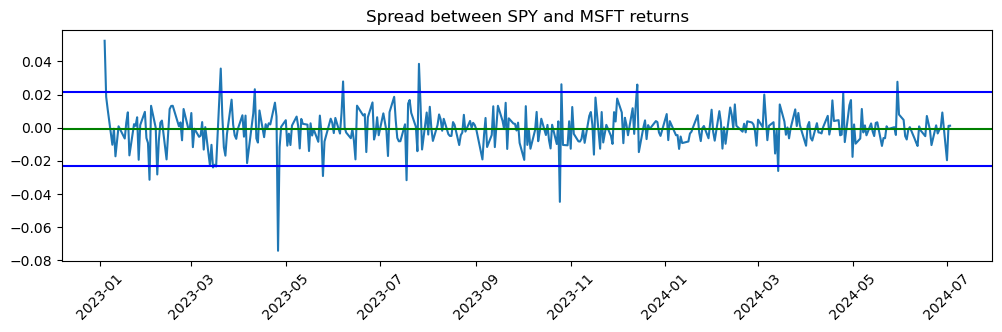

In [28]:
# compute the spread between SPY and MSFT

spread = spy_returns['price'] - msft_returns['price']
mu = float(spread.mean())
sigma = float(spread.std())

plt.figure(figsize=(12, 3))
plt.xticks(rotation=45)
plt.plot(spread)
plt.title('Spread between SPY and MSFT returns')
plt.axhline(mu, color='green')
plt.axhline(mu + 2*sigma, color='blue')
plt.axhline(mu - 2*sigma, color='blue')
plt.show()


In [33]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 5.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 12.9 MB/s eta 0:00:00


In [42]:
# use johansen cointegration test to check if the spread is stationary and obtain the hedge ratio
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05):
    result = coint_johansen(df, det_order=0, k_ar_diff=1)
    trace_stat = result.lr1
    crit_vals = result.cvt[:, 1]
    evec = result.evec
    return trace_stat, crit_vals, trace_stat > crit_vals, evec



In [43]:
# we need to pass the spread as a 2D array
combined_returns = np.column_stack([spy_returns['price'], msft_returns['price']])
trace_stat, crit_vals, result, evec = cointegration_test(combined_returns)
print(f'Trace statistic: {trace_stat}')
print(f'Critical values: {crit_vals}')
print(f'Cointegration test passed: {result}')
print(f'Hedge ratio: {evec[0, 0] / evec[1, 0]}')



Trace statistic: [358.45299626 150.71959665]
Critical values: [15.4943  3.8415]
Cointegration test passed: [ True  True]
Hedge ratio: -0.10112874779655213


In [46]:
# run the test
from statsmodels.tsa.stattools import coint

# Perform the Engle-Granger cointegration test
score, pvalue, _ = coint(spy_returns['price'], msft_returns['price'])

print(f'Engle-Granger p-value: {pvalue}')

# If p-value is less than 0.05, we reject the null hypothesis of no cointegration
if pvalue < 0.05:
    # Perform linear regression to find the hedge ratio
    import statsmodels.api as sm
    model = sm.OLS(spy_returns['price'], sm.add_constant(msft_returns['price'])).fit()
    beta = model.params[1]
    print(f'Hedge Ratio (beta) from Engle-Granger: {beta}')
else:
    print("No significant cointegration relationship found with Engle-Granger method.")

Engle-Granger p-value: 0.0
Hedge Ratio (beta) from Engle-Granger: 0.3449741858263747


In [52]:
# backtest the strategy
# you can only hold 1 position at a time, open a position when the spread is 2 sigma away from the mean and close it when it's back to the mean
# if its below the mean, short SPY and long MSFT, if it's above the mean, long SPY and short MSFT
# given hedge ratio beta 
# and slippage of 0.01% per trade

slippage = 0.0001

def backtest(spread, mu, sigma, beta, price_spy, price_msft):
    # this time i want to track how much of each stock i have at each decision point
    profit = 0
    in_position = False
    spread_side = 0 # 1 for above mean, -1 for below mean
    open_trade_time = 0

    trades = {} # maps timepoint to the amount of each stock we have, following the hedge ratio

    # when we are +- 2sigma away from the mean we should open a position
    # when we cross the mean we should close the position. crossing can be detected by the sign of the spread
    # profit can be taken fromt he price series of the stocks at timepoint t+1

    for t in range(len(spread)):
        if not in_position and spread[t] > mu + 2*sigma:
            in_position = True
            spread_side = 1
            # open position -- long spy, short msft
            trades[t] = {'spy': 1, 'msft': -beta}
            open_trade_time = t
        elif not in_position and spread[t] < mu - 2*sigma:
            in_position = True
            spread_side = -1
            # open position -- short spy, long msft
            trades[t] = {'spy': -1, 'msft': beta}
            open_trade_time = t
        elif in_position and spread_side == 1 and spread[t] < mu:
            in_position = False
            # close position
            # we need the current prices of the stocks to calculate the profit
            # and we need the prices at the time of opening the position
            spy_price_open = price_spy.iloc[open_trade_time]
            msft_price_open = price_msft.iloc[open_trade_time]
            spy_price_close = price_spy.iloc[t]
            msft_price_close = price_msft.iloc[t]
            spy_qty_open = trades[open_trade_time]['spy']
            msft_qty_open = trades[open_trade_time]['msft']
            p = spy_qty_open * (spy_price_close - spy_price_open) + msft_qty_open * (msft_price_close - msft_price_open)
            p -= slippage * p
            profit += p
            trades[t] = {'spy': 0, 'msft': 0}
        elif in_position and spread_side == -1 and spread[t] > mu:
            in_position = False
            # close position
            # we need the current prices of the stocks to calculate the profit
            # and we need the prices at the time of opening the position
            spy_price_open = price_spy.iloc[open_trade_time]
            msft_price_open = price_msft.iloc[open_trade_time]
            spy_price_close = price_spy.iloc[t]
            msft_price_close = price_msft.iloc[t]
            spy_qty_open = trades[open_trade_time]['spy']
            msft_qty_open = trades[open_trade_time]['msft']
            p = spy_qty_open * (spy_price_close - spy_price_open) + msft_qty_open * (msft_price_close - msft_price_open)
            p -= slippage * p
            profit += p
            trades[t] = {'spy': 0, 'msft': 0}

    return profit



backtest(spread, mu, sigma, beta, SPY['price'], MSFT['price'])
  





58.27371290338827